In [4]:
# imports + Globals
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC 
import seaborn as sns

RANDOM_STATE = 42

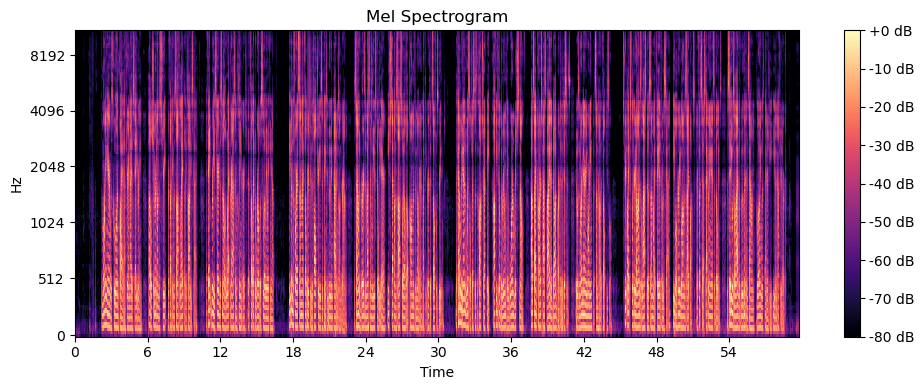

(591, 48)


In [11]:
df = pd.read_csv("../data/audio/processed/audio_features.csv")
df = df.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)

# cool visual for presenttion
y, sr = librosa.load("../data/audio/raw/David.wav", sr=22050)
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
S_db = librosa.power_to_db(S, ref=np.max)
plt.figure(figsize=(10, 4))
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.tight_layout()
plt.show()
print(df.shape)

In [12]:
# slplit data into tain/testing + encode speaker names
x = df.drop(columns="speaker", axis=1)
y = df["speaker"]
y_encoded = df["speaker"].map({"Drake":0, "Melissa":1, "Lisa":2, "Dan":3, "David":4})
x_train, x_test, y_train, y_test = train_test_split(x, y_encoded, test_size=0.20, random_state=RANDOM_STATE)

In [13]:
rf_model = RandomForestClassifier(random_state=RANDOM_STATE)
rf_model.fit(x_train, y_train)
rf_preds = rf_model.predict(x_test)
rf_acc = accuracy_score(y_test, rf_preds)
print(f"Random Forest Model: {rf_acc}")

gb_model = GradientBoostingClassifier(random_state=RANDOM_STATE)
gb_model.fit(x_train, y_train)
gb_preds = gb_model.predict(x_test)
gb_acc = accuracy_score(y_test, gb_preds)
print(f"Gradient Boosting Model: {gb_acc}")

random_forest_grid = {
    'n_estimators': [100, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

Random Forest Model: 0.9747899159663865
Gradient Boosting Model: 0.9663865546218487
